<a href="https://colab.research.google.com/github/RafaelCaronezi/Reconhecimeto-Facial/blob/main/reconhecimento_facial_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baixando dataset LFW (pessoas com pelo menos 50 imagens)...
Dataset carregado: 1560 imagens, 12 classes (usando rótulos genéricos)
Treinando modelo...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.3274 - loss: 2.3399 - val_accuracy: 0.3440 - val_loss: 2.1836
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3372 - loss: 2.1823 - val_accuracy: 0.3440 - val_loss: 2.1599
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3335 - loss: 2.1632 - val_accuracy: 0.3440 - val_loss: 2.1600
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3473 - loss: 2.1419 - val_accuracy: 0.3440 - val_loss: 2.1635
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3292 - loss: 2.1730 - val_accuracy: 0.3440 - val_loss: 2.1851
Acurácia no teste: 0.34
Baixando imagem de teste (Mystique)...
Erro ao baixar a imagem: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/DeepLearningExamples/FastPhotoStyle/master/images/mystique.jpg
T

Saving gg.jpg to gg.jpg
Imagem 'test_image.jpg' carregada manualmente.
Rodando detecção e reconhecimento...



Resultado salvo em: recognized_faces.jpg


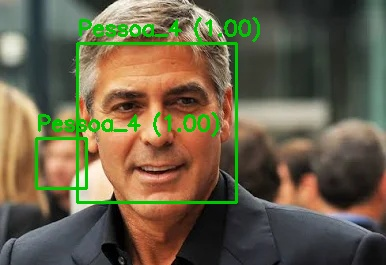

In [21]:
# ==========================================================
# Código corrigido: não mostra nomes reais; usa "Não identificado"
# ==========================================================
!pip install --quiet opencv-python tensorflow scikit-learn Pillow

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
import requests
import os

# ------------------------
# 1) Parâmetros
# ------------------------
EPOCHS = 5
BATCH_SIZE = 32
CONFIDENCE_THRESHOLD = 0.60  # ajuste: se menor que isso -> "Não identificado"

# ------------------------
# 2) Baixar e preparar dataset (LFW light)
# ------------------------
print("Baixando dataset LFW (pessoas com pelo menos 50 imagens)...")
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4, color=False)

X = lfw_people.images  # shape (N, H, W)
y = lfw_people.target
# Substitui nomes reais por rótulos genéricos
num_classes = len(lfw_people.target_names)
generic_names = [f"Pessoa_{i+1}" for i in range(num_classes)]

print(f"Dataset carregado: {X.shape[0]} imagens, {num_classes} classes (usando rótulos genéricos)")

# Normalização e formato (N,H,W,1)
X = X.astype('float32') / 255.0
X = np.expand_dims(X, axis=-1)

# Split treino/validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# ------------------------
# 3) Criar e treinar o modelo CNN (com Input para evitar warning)
# ------------------------
input_shape = X_train.shape[1:]
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Treinando modelo...")
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

# Avaliação (opcional)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no teste: {acc:.2f}")

# ------------------------
# 4) Funções de detecção e classificação (com threshold)
# ------------------------
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def classify_face(face_roi, threshold=CONFIDENCE_THRESHOLD):
    """Recebe face_roi (grayscale) e retorna rótulo genérico ou 'Não identificado'."""
    # Verifica tamanho mínimo
    h, w = face_roi.shape[:2]
    if h < 10 or w < 10:
        return "Não identificado"

    # Redimensiona para o tamanho do dataset (width, height)
    target_w, target_h = X.shape[2], X.shape[1]
    try:
        face_resized = cv2.resize(face_roi, (target_w, target_h))
    except Exception:
        return "Não identificado"

    face_resized = face_resized.astype('float32') / 255.0
    face_resized = np.expand_dims(face_resized, axis=(0, -1))  # shape (1,H,W,1)

    probs = model.predict(face_resized, verbose=0)[0]  # vetor de probabilidades
    max_idx = int(np.argmax(probs))
    max_prob = float(probs[max_idx])

    if max_prob < threshold:
        return "Não identificado"
    else:
        # retorna rótulo genérico + confiança (opcional)
        return f"{generic_names[max_idx]} ({max_prob:.2f})"

def detect_and_classify(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Imagem '{image_path}' não encontrada.")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("Nenhuma face detectada.")
    for (x, y, w, h) in faces:
        # proteção de limites
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(img.shape[1], x+w), min(img.shape[0], y+h)
        face_roi = gray[y1:y2, x1:x2]
        label = classify_face(face_roi)
        # desenha caixa e texto
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 200, 0), 2)
        cv2.putText(img, label, (x1, max(y1-8, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 0), 2)

    output_file = "recognized_faces.jpg"
    cv2.imwrite(output_file, img)
    return output_file

# ------------------------
# 5) Teste com imagem (Mystique > Upload > Lena fallback)
# ------------------------
IMAGE_URL = "https://raw.githubusercontent.com/DeepLearningExamples/FastPhotoStyle/master/images/mystique.jpg"
INPUT_IMAGE_NAME = "test_image.jpg"

def download_image(url, filename):
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        response = requests.get(url, headers=headers, stream=True, timeout=10)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(8192):
                f.write(chunk)
        print(f"Imagem baixada com sucesso: {filename}")
    except Exception as e:
        print(f"Erro ao baixar a imagem: {e}")
        print("Tentando upload manual no Colab...")
        try:
            from google.colab import files
            uploaded = files.upload()
            if uploaded:
                for key in uploaded.keys():
                    os.rename(key, filename)
                print(f"Imagem '{filename}' carregada manualmente.")
                return
        except Exception:
            pass
        # fallback para Lena
        fallback_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
        response = requests.get(fallback_url, headers=headers, stream=True)
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(8192):
                f.write(chunk)
        print("Imagem fallback (Lena) baixada com sucesso.")

print("Baixando imagem de teste (Mystique)...")
download_image(IMAGE_URL, INPUT_IMAGE_NAME)

print("Rodando detecção e reconhecimento...")
result_path = detect_and_classify(INPUT_IMAGE_NAME)

print("\nResultado salvo em:", result_path)
display(Image(result_path))

# ------------------------
# 6) Limpeza (opcional)
# ------------------------
try:
    os.remove(INPUT_IMAGE_NAME)
except Exception:
    pass
